
<a id='chap-tpestimationdensitenoyaux'></a>

# Travaux pratiques - Estimation de densité par noyaux

**Objectif:** utilisation de Scikit-learn concernant l’estimation de densité par noyaux, et contribution à une meilleure compréhension de cette méthode et de l’impact de la distribution des données sur les résultats. 

Gilles Cohen | gilles.cohen@univ.lyon1.fr

M2 - UCBL Université Lyon.

## L’estimation de densités dans Scikit-learn

Pour estimer des densités, Scikit-learn propose les histogrammes et les noyaux comme méthodes non paramétriques, et les modèles de mélange comme méthodes paramétriques. Manquent, en revanche, des outils de choix du paramètre unique (largeur de « fenêtre ») pour les méthodes non paramétriques et des outils de comparaison entre densités (même lorsque celles-ci sont issues de mélanges de lois normales).

Les méthodes non paramétriques proposées sont présentées dans [sklearn.density](http://scikit-learn.org/stable/modules/density.html) et l’utilisation de modèles de mélange dans [sklearn.mixture](http://scikit-learn.org/stable/modules/mixture.html).

## Estimation par noyaux

Afin de permettre la visualisation des résultats et sachant que des outils de comparaison entre densités ne sont pas directement accessibles, nous examinerons uniquement des données unidimensionnelles et bidimensionnelles.

La description de l’implémentation de l’estimation de densités par noyaux se trouve dans [KernelDensity](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html).

Le type de noyau est spécifié dans le paramètre `kernel` est il est possible d’utiliser comme valeurs `'gaussian'` (choix par défaut), `'tophat'`, `'epanechnikov'`, `'exponential'`, `'linear'` ou `'cosine'`. Une fois le type de noyau choisi, tous les noyaux (ou « fenêtres ») employés présentent une même valeur pour l’unique paramètre de largeur de « fenêtre » appelé ici `bandwidth`.

Il faut noter que le coût du calcul de la densité en un point donné peut être élevé si l’ensemble d’observations à partir duquel l’estimation de densité a été réalisée est très volumineux (en effet, cela impose de calculer la valeur du noyau entre le point donné et chacune des observations de départ !). Pour réduire le coût de calcul, on observe que les noyaux sont « localisés », c’est à dire leur valeur est numériquement non nulle seulement pour une valeur relativement faible de la norme de la différence entre les arguments ; la valeur du noyau calculé entre un point et une observation très éloignée est ainsi assimilable à 0 et il n’est donc pas nécessaire de faire le calcul. Il est alors possible d’utiliser un index spatial (ici de type *KD tree* ou *Ball tree*, `algorithm ['kd_tree'|'ball_tree'|'auto']`) pour éviter de calculer le noyau entre données trop éloignées les unes des autres.

Les méthodes qui peuvent être employées :

- `fit(X, y=None)` : calcul du modèle à partir des observations qui sont les lignes de X.  
- `sample([n_samples, random_state])` : générer un échantillon (composé de `n_samples` données) à partir du modèle (pour le moment, accessible seulement pour les noyaux `'gaussian'` et `'tophat'`).  
- `score(X, y=None)` : retourne la log-vraisemblance totale des données de X par rapport au modèle.  
- `score_samples(X)` : retourne le logarithme de la densité calculée pour chaque donnée de X.  
- `get_params([deep])` : lire les valeurs des paramètres de l’estimateur employé.  
- `set_params(**params)` : donner des valeurs aux paramètres de l’estimateur employé.  

### Estimation à partir de données générées

Cette partie de la séance a pour objectif de faire comprendre l’impact des différents aspects qui interviennent dans l’estimation par noyaux : le volume de données, le choix du noyau, le paramètre d’échelle (`bandwidth`, correspondant en général à la variance du noyau). Pour cela, nous générons des données à partir d’une densité connue, estimons la densité à partir de ces données et comparons le résultat de l’estimation à la densité qui a généré les données.

Une première utilisation sur des données unidimensionnelles, sur lesquelles il est possible d’afficher à la fois la vraie densité et la densité estimée :

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from sklearn.neighbors import KernelDensity

# générer l'échantillon à partir de deux lois normales
N = 100
X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
                    np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]

# préparer les points où on calculera la densité
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

# préparation de l'affichage de la vraie densité, qui est celle à partir
#  de laquelle les données ont été générées (voir plus haut)
# la pondération des lois dans la somme est la pondération des lois
#  dans l'échantillon généré (voir plus haut)
true_density = (0.3 * norm(0,1).pdf(X_plot[:,0]) + 0.7 * norm(5,1).pdf(X_plot[:,0]))

La variable `true_density` correspond à la distribution réelle de nos données. En pratique, celle-ci est inconnue et nous cherchons à l’estimer.
Pour ce faire, nous allons utiliser la méthode des noyaux.

In [2]:
# estimation de densité par noyaux gaussiens
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X)

Nous pouvons ensuite calculer, pour chaque valeur de `X_plot`, la probabilité d’occurrence de cette valeur. Cela permet de tracer la densité estimée.

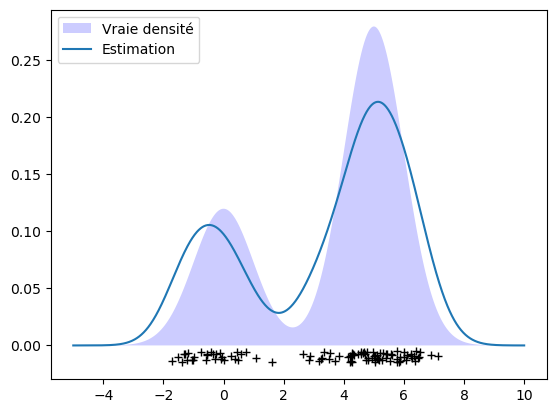

In [3]:
# calcul de la densité pour les données de X_plot
density = np.exp(kde.score_samples(X_plot))

# affichage : vraie densité et estimation
fig = plt.figure()
ax = fig.add_subplot(111)
ax.fill(X_plot[:,0], true_density, fc='b', alpha=0.2, label='Vraie densité')
ax.plot(X_plot[:,0], density, '-', label="Estimation")
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')
ax.legend(loc='upper left')
plt.show()

### Question :

Faites varier la taille de l’échantillon et examinez les résultats.

### Question :

Faites varier le nombre de lois normales lors de la génération de l’échantillon et examinez les résultats.

### Question :

Faites varier la valeur de `bandwidth` et examinez les résultats.

### Question :

Faites varier le type de noyau et examinez les résultats.

Il est possible de générer de nouvelles données suivant cette densité estimée et de visualiser le résultat d’une nouvelle estimation faite à partir de ces dernières données :

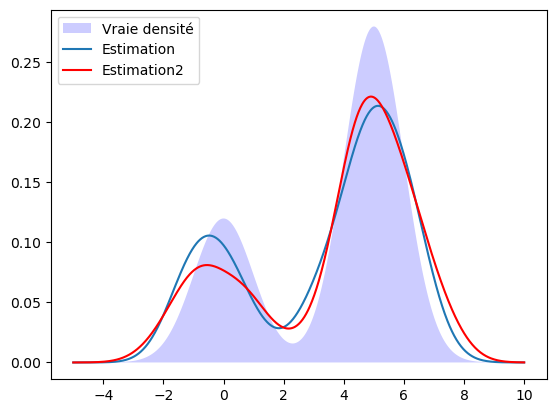

In [4]:
Xg = kde.sample(N)
kde2 = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(Xg)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.fill(X_plot[:,0], true_density, fc='b', alpha=0.2, label='Vraie densité')
ax.plot(X_plot[:,0], density, '-', label="Estimation")
ax.plot(X_plot[:,0], np.exp(kde2.score_samples(X_plot)), 'r-', label="Estimation2")
ax.legend(loc='upper left')
plt.show()

Une deuxième utilisation de l’estimation de densité par noyaux sur des données bidimensionnelles, sur lesquelles il n’est malheureusement plus possible de bien visualiser à la fois la vraie densité et la densité estimée :

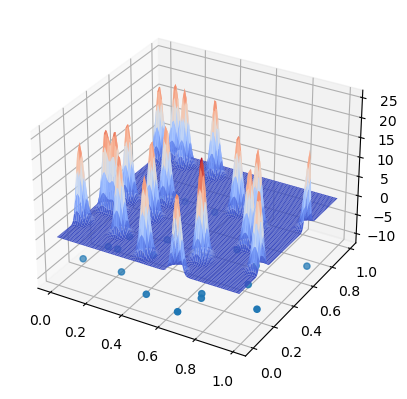

In [5]:
# générer l'échantillon
N = 20
kd = np.random.rand(N, 2)

# définir la grille pour la visualisation
grid_size = 100
Gx = np.arange(0, 1, 1/grid_size)
Gy = np.arange(0, 1, 1/grid_size)
Gx, Gy = np.meshgrid(Gx, Gy)

# définir la largeur de bande pour le noyau
bw = 0.02

# estimation, puis calcul densité sur la grille
kde3 = KernelDensity(kernel='gaussian', bandwidth=bw).fit(kd)
Z = np.exp(kde3.score_samples(np.hstack(((Gx.reshape(grid_size*grid_size))[:,np.newaxis],
        (Gy.reshape(grid_size*grid_size)[:,np.newaxis])))))

# affichage
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(Gx, Gy, Z.reshape(grid_size,grid_size), rstride=1,
                    cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax.scatter(kd[:,0], kd[:,1], -10)
plt.show()

### Question :

Faites varier la valeur de `bandwidth` et examinez les résultats.

### Question :

Générez l’échantillon à partir d’une somme de 2 lois normales différentes (avec `N` plus grand) et examinez les résultats.

Pour mieux comprendre ce qu’est une estimation de densité par noyaux, il peut être utile de construire le modèle et visualiser les résultats directement, sans passer par la classe spécifique de scikit-learn. En effet, dans l’estimation de densité par noyaux il n’y a pas de « modèle synthétique » obtenu à partir des N données (ou observations) de départ, le modèle de densité est constitué par les N noyaux centrés sur ces N données.

Pour la visualisation directe nous nous servirons de la fonction de calcul d’une loi normale bidimensionelle en `(x,y)`, `bivariate_normal(x,y,sigmax,sigmay,mux,muy,sigmaxy)`, où `sigmax` est la variance de X, `sigmay` la variance de Y, `sigmaxy` la covariance entre X et Y, `mux` la moyenne de X et `muy` la moyenne de Y.

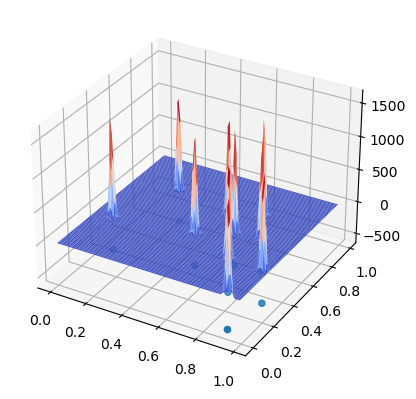

In [6]:
# générer l'échantillon
N = 10
kd = np.random.rand(N, 2)

# définir la grille pour la visualisation
grid_size = 100
Gx = np.arange(0, 1, 1/grid_size)
Gy = np.arange(0, 1, 1/grid_size)
Gx, Gy = np.meshgrid(Gx, Gy)
bw = 0.01

# calcul direct de la densité sur la grille
from scipy.stats import multivariate_normal
Z = np.zeros((grid_size,grid_size))
for i in range(N):
    # génération d'une loi normale bidimensionnelle centrée sur le point kd[i] et d'écart-type bw
    Z = Z + multivariate_normal.pdf(np.dstack((Gx, Gy)),
                                    mean=[kd[i,0], kd[i,1]], cov=[[bw**2, 0], [0, bw**2]])

# affichage
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(Gx, Gy, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                    linewidth=0, antialiased=True)
ax.scatter(kd[:,0], kd[:,1], -500)
plt.show()